In [85]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pickle
import kaggle

%matplotlib inline

Import the dataset

In [86]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('yasserh/loan-default-dataset', path='../backend/data/raw/', unzip=True)
loan_df = pd.read_csv('../backend/data/raw//Loan_Default.csv')

Dataset URL: https://www.kaggle.com/datasets/yasserh/loan-default-dataset


# Logistic Regression 

In [87]:
print(loan_df['Status'].value_counts())

0    112031
1     36639
Name: Status, dtype: int64


In [88]:
loan_df = loan_df[~loan_df['Gender'].str.contains("Not Available")]
print(loan_df['Status'].value_counts())

0    85139
1    25872
Name: Status, dtype: int64


## Missings

In [89]:
# All or mostly missing where status = 1
loan_df = loan_df.drop(columns=['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges'])
dict_na = {
    'loan_limit': loan_df['loan_limit'].mode()[0],
    'approv_in_adv': loan_df['approv_in_adv'].mode()[0],
    'loan_purpose': loan_df['loan_purpose'].mode()[0],
    'term': loan_df['term'].mode()[0],
    'Neg_ammortization': loan_df['Neg_ammortization'].mode()[0],
    'property_value': loan_df['property_value'].mean(),
    'income': loan_df['income'].mean(),
    'LTV': loan_df['LTV'].mean(),
    'dtir1': loan_df['dtir1'].mean()
}
loan_df = loan_df.fillna(dict_na)
assert loan_df.isnull().sum().sum() == 0
display(loan_df)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,360.0,not_neg,not_int,lpsm,5.153947e+05,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,73.114587,North,direct,1,37.735953
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,360.0,neg_amm,not_int,not_lpsm,5.080000e+05,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.000000
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,360.0,not_neg,not_int,not_lpsm,6.580000e+05,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.000000
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,360.0,not_neg,not_int,not_lpsm,7.580000e+05,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.000000
5,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,706500,360.0,not_neg,not_int,not_lpsm,1.008000e+06,sb,pr,home,1U,10080.0,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148664,173554,2019,cf,Joint,nopre,type2,p1,l1,nopc,b/c,156500,360.0,not_neg,not_int,not_lpsm,1.580000e+05,sb,pr,home,1U,4020.0,EXP,859,EXP,65-74,to_inst,99.050633,central,direct,0,45.000000
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,586500,360.0,not_neg,not_int,not_lpsm,7.880000e+05,sb,ir,home,4U,7140.0,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.000000
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,446500,180.0,not_neg,not_int,not_lpsm,7.280000e+05,sb,pr,home,1U,6900.0,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.000000
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,196500,180.0,not_neg,not_int,not_lpsm,2.780000e+05,sb,pr,home,1U,7140.0,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.000000


## Feature Engineering

In [90]:
obj_cols = loan_df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = encoder.fit_transform(loan_df[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(obj_cols))

loan_df = loan_df.reset_index(drop=True)
one_hot_df = one_hot_df.reset_index(drop=True)
# Concatenate the one-hot encoded dataframe with the dataframe
df_encoded = pd.concat([loan_df, one_hot_df], axis=1)
print(loan_df.shape)

# Drop the original categorical columns
df_encoded = df_encoded.drop(obj_cols, axis=1)

# Display the resulting dataframe
display(df_encoded)

(111011, 31)


,ID,year,loan_amount,term,property_value,income,Credit_Score,LTV,Status,dtir1,loan_limit_ncf,Gender_Joint,Gender_Male,approv_in_adv_pre,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l2,open_credit_opc,business_or_commercial_nob/c,Neg_ammortization_not_neg,interest_only_not_int,lump_sum_payment_not_lpsm,construction_type_sb,occupancy_type_pr,occupancy_type_sr,Secured_by_land,total_units_2U,total_units_3U,total_units_4U,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_EXP,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,Security_Type_direct
0,24891,2019,206500,360.0,5.153947e+05,4980.0,552,73.114587,1,37.735953,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,24892,2019,406500,360.0,5.080000e+05,9480.0,834,80.019685,0,46.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,24893,2019,456500,360.0,6.580000e+05,11880.0,587,69.376900,0,42.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,24894,2019,696500,360.0,7.580000e+05,10440.0,602,91.886544,0,39.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,24895,2019,706500,360.0,1.008000e+06,10080.0,864,70.089286,0,40.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111006,173554,2019,156500,360.0,1.580000e+05,4020.0,859,99.050633,0,45.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
111007,173556,2019,586500,360.0,7.880000e+05,7140.0,569,74.428934,0,15.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
111008,173557,2019,446500,180.0,7.280000e+05,6900.0,702,61.332418,0,49.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111009,173558,2019,196500,180.0,2.780000e+05,7140.0,737,70.683453,0,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [91]:
X = df_encoded.drop(columns=['ID', 'Status'])
y = df_encoded['Status']

In [93]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2,  random_state=12)

In [96]:
clf_cv = LogisticRegressionCV(cv=10, random_state=0, max_iter=2000, penalty='l1', solver='liblinear').fit(X, y)
print(clf_cv.scores_[1])
# scores = cross_val_score(clf_cv, X, y, cv=5)
# print('The model correctly classified,', round(scores.mean()*100,2), 'percent of observations.')

[[0.76688885 0.86903261 0.87083408 0.87326608 0.8735363  0.87344623
  0.87290578 0.87290578 0.87299586 0.87299586]
 [0.76677777 0.86217458 0.86775966 0.86920097 0.86920097 0.86920097
  0.86938114 0.86929105 0.86947122 0.86920097]
 [0.76695793 0.86694892 0.8715431  0.87316458 0.87361499 0.8740654
  0.87343483 0.87370507 0.87352491 0.87343483]
 [0.76686785 0.86181425 0.86631835 0.86983155 0.87046212 0.87073237
  0.87073237 0.87064228 0.87064228 0.87064228]
 [0.76686785 0.86172417 0.86694892 0.86848032 0.86974146 0.86974146
  0.86974146 0.86965138 0.86974146 0.86983155]
 [0.76695793 0.86703901 0.87037204 0.8705522  0.87091253 0.87082245
  0.87100261 0.87082245 0.87091253 0.87091253]
 [0.76695793 0.86469687 0.86947122 0.8715431  0.8715431  0.87163319
  0.87172327 0.87199351 0.87199351 0.87199351]
 [0.76695793 0.86622827 0.86802991 0.8705522  0.87091253 0.87091253
  0.87082245 0.8705522  0.8705522  0.87064228]
 [0.76686785 0.86289523 0.86784974 0.86992163 0.87019187 0.87019187
  0.87019187 

## Pickle the model

In [97]:
pickle.dump(clf_cv, open("../backend/api/endpoints/dependencies/logreg_model.pickle", "wb"))

In [99]:
with open("../backend/api/endpoints/dependencies/logreg_model.pickle", 'rb') as f:
    model = pickle.load(f)

In [100]:
testing = test_X[:10]
display(testing)

,year,loan_amount,term,property_value,income,Credit_Score,LTV,dtir1,loan_limit_ncf,Gender_Joint,Gender_Male,approv_in_adv_pre,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l2,open_credit_opc,business_or_commercial_nob/c,Neg_ammortization_not_neg,interest_only_not_int,lump_sum_payment_not_lpsm,construction_type_sb,occupancy_type_pr,occupancy_type_sr,Secured_by_land,total_units_2U,total_units_3U,total_units_4U,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_EXP,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,Security_Type_direct
107485,2019,426500,360.0,578000.000000,8640.0,852,73.788927,20.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
34527,2019,146500,360.0,515394.709502,5220.0,560,73.114587,37.735953,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
76907,2019,446500,360.0,658000.000000,5400.0,851,67.857143,45.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33360,2019,396500,360.0,528000.000000,7440.0,676,75.094697,27.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
106859,2019,306500,360.0,448000.000000,4740.0,754,68.415179,46.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102092,2019,376500,360.0,488000.000000,8220.0,823,77.151639,24.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
74689,2019,376500,360.0,418000.000000,8700.0,681,90.071770,10.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
108502,2019,486500,360.0,708000.000000,28980.0,632,68.714689,10.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
96298,2019,366500,360.0,378000.000000,5880.0,630,96.957672,38.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
82295,2019,536500,360.0,568000.000000,8580.0,848,94.454225,40.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [101]:
predictions = model.predict(testing)

In [104]:
#print the feature names in the model
print(model.feature_names_in_)

['year' 'loan_amount' 'term' 'property_value' 'income' 'Credit_Score'
 'LTV' 'dtir1' 'loan_limit_ncf' 'Gender_Joint' 'Gender_Male'
 'approv_in_adv_pre' 'loan_type_type2' 'loan_type_type3' 'loan_purpose_p2'
 'loan_purpose_p3' 'loan_purpose_p4' 'Credit_Worthiness_l2'
 'open_credit_opc' 'business_or_commercial_nob/c'
 'Neg_ammortization_not_neg' 'interest_only_not_int'
 'lump_sum_payment_not_lpsm' 'construction_type_sb' 'occupancy_type_pr'
 'occupancy_type_sr' 'Secured_by_land' 'total_units_2U' 'total_units_3U'
 'total_units_4U' 'credit_type_CRIF' 'credit_type_EQUI' 'credit_type_EXP'
 'co-applicant_credit_type_EXP' 'age_35-44' 'age_45-54' 'age_55-64'
 'age_65-74' 'age_<25' 'age_>74' 'submission_of_application_to_inst'
 'Region_North-East' 'Region_central' 'Region_south'
 'Security_Type_direct']


# Archive

In [3]:
loan_df = pd.read_csv('Raw Data/Loan_Default.csv')

Rate of interest, interest rate spread and upfront charges are all missing a lot of status = 1, so I am going to drop them as they likely are causing data leakage in my model which is why I'm getting 100% accuracy.

In [4]:
y = loan_df['Status']
loan_df = loan_df.drop(columns=['Status', 'ID', 'rate_of_interest','Interest_rate_spread', 'Upfront_charges'])

In [5]:
loan_df['year'] = str(loan_df['year'])
cat = loan_df[make_column_selector(dtype_include= object)]
dfohe = DataFrameOneHotEncoder()
catx = dfohe.fit_transform(cat)

In [6]:
numdf = loan_df[make_column_selector(dtype_include= np.number)]
ss = StandardScaler()
numx = pd.DataFrame(ss.fit_transform(numdf), columns=numdf.columns)

transformer = make_column_transformer(
                (StandardScaler(), make_column_selector(dtype_include = np.number)),
                (DataFrameOneHotEncoder(), make_column_selector(dtype_include = object)))
X = transformer.fit_transform(loan_df)


In [7]:
X = numx.join(catx)

In [16]:
numx.isna().sum()

loan_amount           0
term                 41
property_value    15098
income             9150
Credit_Score          0
LTV               15098
dtir1             24121
dtype: int64

In [8]:
X = X.fillna(value =0)

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2,  random_state=12)

In [11]:
test_X.to_csv('./testX.csv')
test_y.to_csv('./testy.csv')

Logistic Regression

In [56]:

#the grid of parameters to search over
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}


logreg = LogisticRegression(max_iter=1000)
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 


clf.fit(train_X,train_y)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)


/Users/kaylawilding/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kaylawilding/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kaylawilding/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/kaylawilding/opt/anac

Tuned Hyperparameters : {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.8647592616191193


In [12]:
best_logreg = LogisticRegression(max_iter=1000, C=100, penalty='l1', solver = 'liblinear')
best_logreg.fit(train_X, train_y)
y_pred = best_logreg.predict(test_X)

print("Accuracy:",best_logreg.score(test_X, test_y))

Accuracy: 0.8635568709221766


In [30]:
decision_tree = DecisionTreeClassifier()

params = {
    "criterion" : ['gini', 'entropy'],
    "max_depth" : range(1,5),
    "min_samples_split" : range(2,5),
    "min_samples_leaf": range(1,5)
}
grid = GridSearchCV(decision_tree, 
                param_grid = params, 
                cv = 5,
                verbose = 1,
                n_jobs = -1)

grid.fit(train_X, train_y)
            

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 5)},
             verbose=1)

In [31]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [32]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [11]:
best_tree_class = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, min_samples_split =2, min_samples_leaf = 1)
#best_tree_class = grid.best_estimator_
best_tree_class.fit(train_X, train_y)

y_pred_tree = best_tree_class.predict(test_X)

print("Accuracy:",best_tree_class.score(test_X, test_y))

Accuracy: 0.8754288020447972


In [36]:
best_tree_class.decision_path

<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(max_depth=4)>

In [35]:
importances = best_tree_class.feature_importances_
important_features = pd.DataFrame(importances[importances > 0],columns=['importance_val'])
important_feature_names = pd.DataFrame(X.columns[importances > 0], columns = ['feature_name'])
important_features_selected = pd.merge(important_features, important_feature_names, how = 'left', left_index = True, right_index = True)
important_features_selected

,importance_val,feature_name
0,0.035333,LTV
1,0.062673,dtir1
2,0.040630,loan_type[loan_type_type1]
3,0.003991,Neg_ammortization[Neg_ammortization_not_neg]
4,0.038157,lump_sum_payment[lump_sum_payment_not_lpsm]
5,0.816919,credit_type[credit_type_EQUI]
6,0.002297,submission_of_application[submission_of_applic...


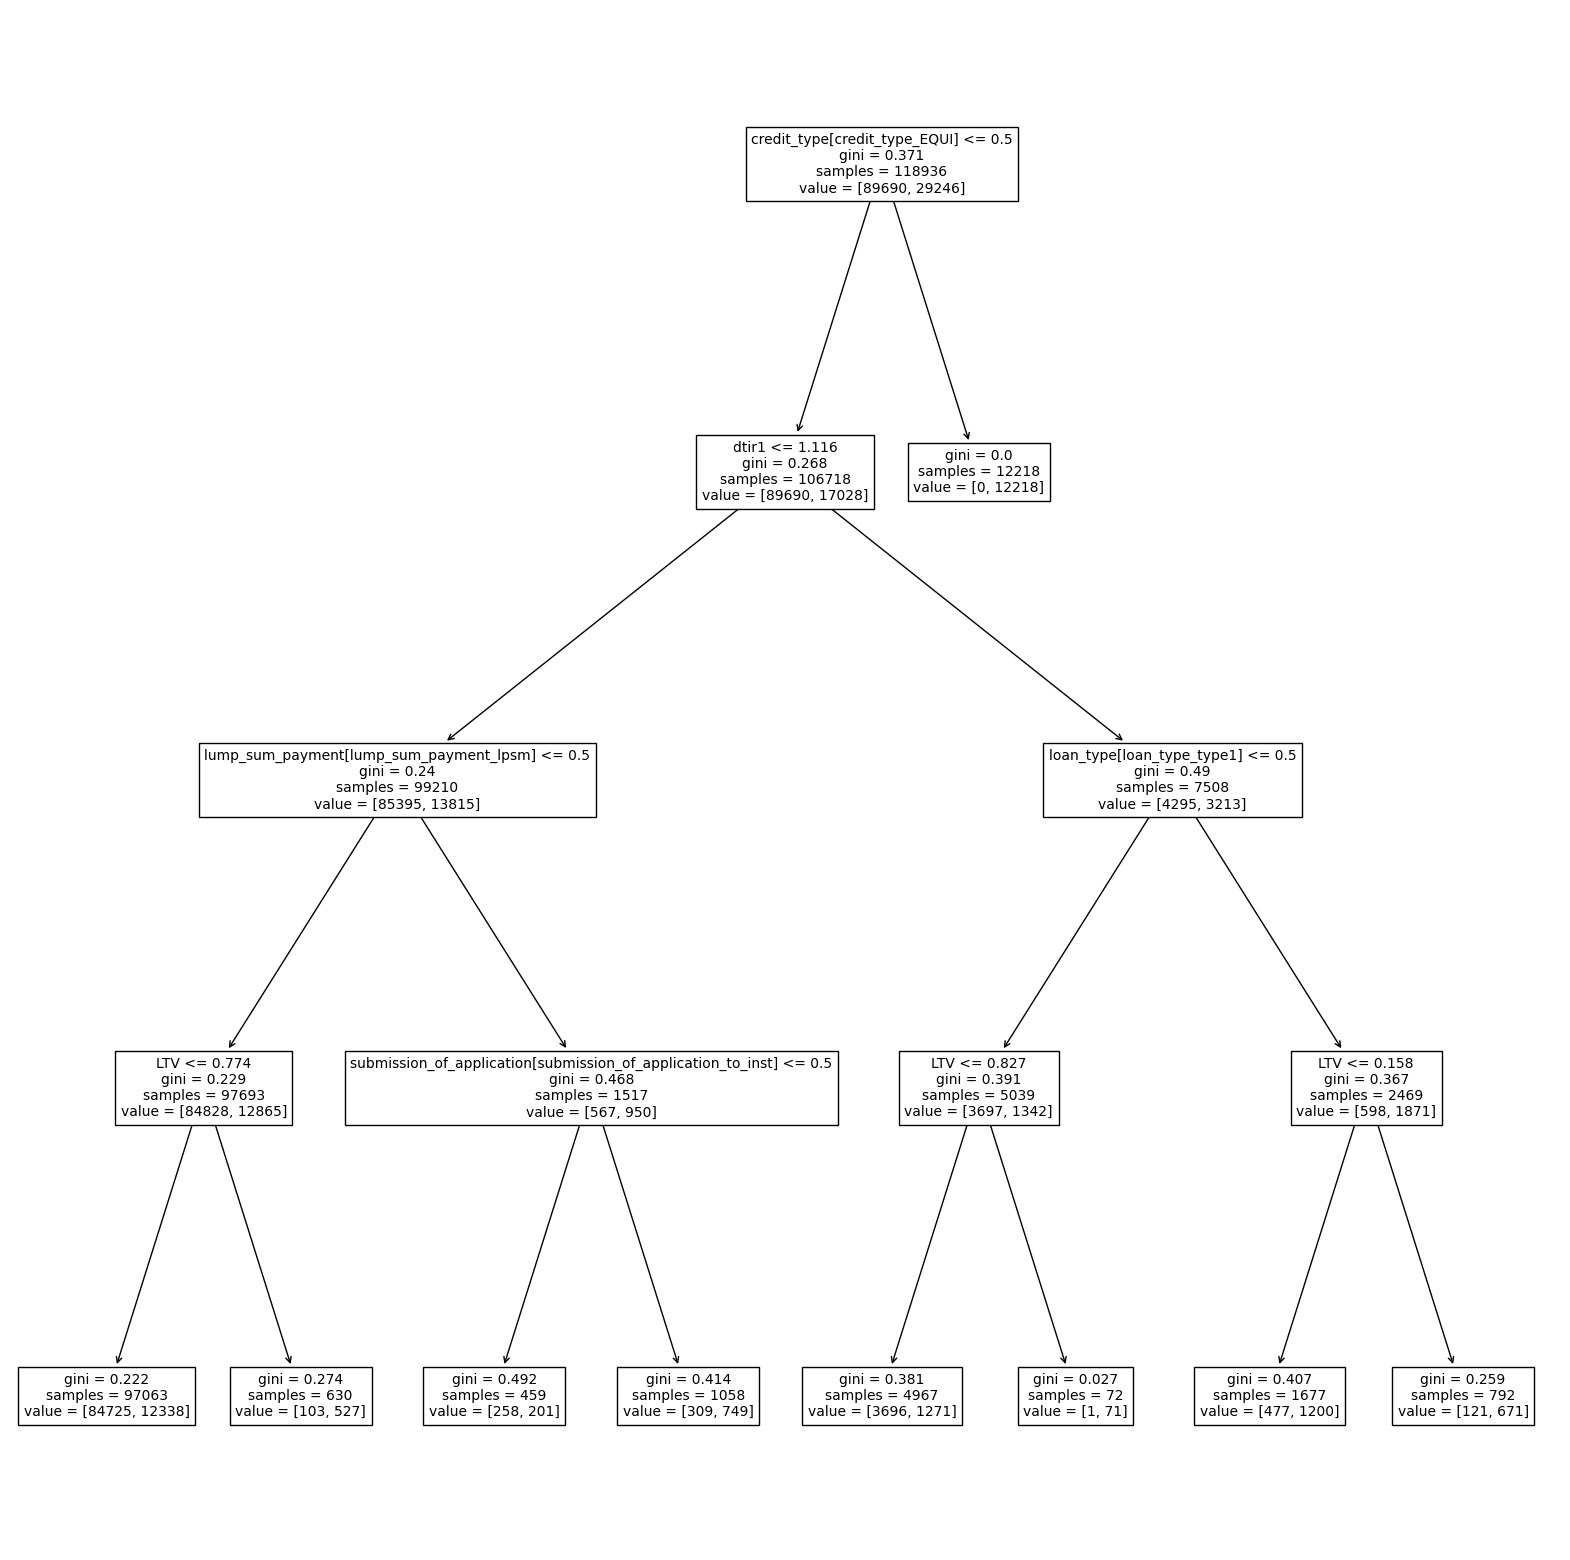

In [50]:
plt.figure(figsize = (20,20))
plot_tree(best_tree_class, feature_names = best_tree_class.feature_names_in_, fontsize=10)
plt.show()

In [55]:
groups = df_orig.groupby(['Status','credit_type'])
groups.size()

Status  credit_type
0       CIB            40542
        CRIF           36774
        EQUI               1
        EXP            34714
1       CIB             7610
        CRIF            7127
        EQUI           15297
        EXP             6605
dtype: int64

XGBoost Forest Model


In [37]:
train_X.columns = train_X.columns.str.replace("[[]", "_")
train_X.columns = train_X.columns.str.replace("[]]", "_")
train_X.columns = train_X.columns.str.replace("[<]", "less_than")
train_X.columns = train_X.columns.str.replace("[>]", "greater_than")
test_X.columns = test_X.columns.str.replace("[[]", "_")
test_X.columns = test_X.columns.str.replace("[]]", "_")
test_X.columns = test_X.columns.str.replace("[<]", "less_than")
test_X.columns = test_X.columns.str.replace("[>]", "greater_than")

/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_64026/1188698962.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X.columns = train_X.columns.str.replace("[[]", "_")
/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_64026/1188698962.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X.columns = train_X.columns.str.replace("[]]", "_")
/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_64026/1188698962.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X.columns = train_X.columns.str.replace("[<]", "less_than")
/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_64026/1188698962.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X.columns = train_X.columns.str.replace("[>]", "greater_than")


Index(['loan_amount', 'term', 'property_value', 'income', 'Credit_Score',
       'LTV', 'dtir1',
       'year_year_0         2019\n1         2019\n2         2019\n3         2019\n4         2019\n          ... \n148665    2019\n148666    2019\n148667    2019\n148668    2019\n148669    2019\nName: year, Length: 148670, dtype: int64_',
       'loan_limit_loan_limit_cf_', 'loan_limit_loan_limit_ncf_',
       'loan_limit_loan_limit_nan_', 'Gender_Gender_Female_',
       'Gender_Gender_Joint_', 'Gender_Gender_Male_',
       'Gender_Gender_Sex Not Available_',
       'approv_in_adv_approv_in_adv_nopre_',
       'approv_in_adv_approv_in_adv_pre_', 'approv_in_adv_approv_in_adv_nan_',
       'loan_type_loan_type_type1_', 'loan_type_loan_type_type2_',
       'loan_type_loan_type_type3_', 'loan_purpose_loan_purpose_p1_',
       'loan_purpose_loan_purpose_p2_', 'loan_purpose_loan_purpose_p3_',
       'loan_purpose_loan_purpose_p4_', 'loan_purpose_loan_purpose_nan_',
       'Credit_Worthiness_Credit

In [43]:
# fit model on training data
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
xgbmodel = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
grid_search = GridSearchCV(
    estimator=xgbmodel,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(train_X, train_y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='roc_auc', verbose=True)

In [44]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

In [46]:
# Dictionary of best parameters
best_xgb_params = grid_search.best_params_
# Best XGB model that was found based on the metric score you specify
best_xgb_model = grid_search.best_estimator_
# Save model
pickle.dump(grid_search.best_estimator_, open("xgb_model.pickle", "wb"))

In [47]:
# make predictions for test data
y_pred = best_xgb_model.predict(test_X)
predictions = [round(value) for value in y_pred]

In [48]:
# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.71%
